In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
sns.set_theme()
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from transformers import BertTokenizer, BertModel
import torch

# import my_utils
# from my_utils import essay_to_wordlist, essay_to_sentences, makeFeatureVec, getAvgFeatureVecs, get_model

In [76]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Charger le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_essays(essay_v, remove_stopwords):
    
    #Remove the tagged labels and word tokenize the sentence.
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    
    # Convertir en minuscules
    words = essay_v.lower()
    
    # Supprimer les espaces supplémentaires
    words = re.sub(r'\s+', ' ',words).strip()
    
    # Tokenize the words C'est a dire en liste de mots solitaires
    words = words.split()
    
    # Supprimer les stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
        words = [lemmatizer.lemmatize(w) for w in words ]
    return (words)

def get_bert_embedding(words):
    # Tokenisation et création des tenseurs
    inputs = tokenizer(words, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Obtenir les embeddings
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings



def get_bert_embeddings(text):
    # Tokenize the text and truncate to a maximum length of 512 tokens
    input_ids = tokenizer.encode(text, max_length=512, truncation=True, return_tensors='pt')
    attention_mask = (input_ids != 0).float()

    # Get the output from the BERT model
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)[0]

    # Average the token representations to get a representation of the text
    return output.mean(dim=1).squeeze().detach().numpy()
    
# Convertir les tenseurs en tableaux NumPy et prendre la moyenne sur la dimension des séquences
def get_avg_embeddings(embeddings):
    avg_embeddings = []
    for emb in embeddings:
        # Convertir le tenseur en NumPy et en float32
        emb_np = emb.numpy().astype(np.float32)
        # Prendre la moyenne sur la dimension des séquences (axis=1)
        avg_emb = np.mean(emb_np, axis=1)
        avg_embeddings.append(avg_emb)
    return np.array(avg_embeddings, dtype=np.float32)


def getFeatureVecs(essays, num_features=768):
    """Main function to generate the word vectors for Bert model."""
    features_matrix = np.zeros((len(essays), num_features), dtype="float32")
    for counter, essay in enumerate(essays):
        features_matrix[counter] = essay
    return features_matrix


def get_model():
    """Define the model."""
    model = Sequential()
    model.add(Bidirectional(GRU(768, dropout=0.4, recurrent_dropout=0, return_sequences=True), input_shape=(1, 768)))
    model.add(Bidirectional(GRU(64, recurrent_dropout=0)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model


[nltk_data] Downloading package stopwords to C:\Users\SEBEOGO Landry
[nltk_data]     Yves\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\SEBEOGO Landry
[nltk_data]     Yves\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\SEBEOGO Landry
[nltk_data]     Yves\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
df = pd.read_csv(r'C:\Users\SEBEOGO Landry Yves\Desktop\My folders\Freelance\essay score prediction\training_set_rel3.tsv', delimiter='\t', encoding='ISO-8859-1',
  )

In [69]:
get_bert_embeddings(clean_essays(df["essay"][0],True)).shape

(768,)

In [70]:
get_bert_embeddings(clean_essays(df["essay"][1],True)).shape

(768,)

In [71]:
# Check total missing values
print(df.isnull().sum())

essay_id              0
essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64


In [72]:
X=df["essay"]
y=df["domain1_score"]

In [73]:
X.head()

0    Dear local newspaper, I think effects computer...
1    Dear @CAPS1 @CAPS2, I believe that using compu...
2    Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...
3    Dear Local Newspaper, @CAPS1 I have found that...
4    Dear @LOCATION1, I know having computers has a...
Name: essay, dtype: object

In [74]:
y.tail()

12971    35
12972    32
12973    40
12974    40
12975    40
Name: domain1_score, dtype: int64

# 5-Fold Cross Validation Training

In [77]:
# 5-Fold Cross Validation Training
cv = KFold(n_splits=2, shuffle=True)
results = []
y_pred_list = []

clf_model = get_model()

for count, (traincv, testcv) in enumerate(cv.split(X)):
    print("\n--------Fold {}--------\n".format(count + 1))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]

    print("Making the embedding of the Data...")


    # Initialize the progress bar for training data
    Training_embeddings = []
    for essay_v in tqdm(X_train, desc="Processing Training Data"):
        Training_embeddings.append(get_bert_embeddings(clean_essays(essay_v,True)))
    trainDataVecs = getFeatureVecs(Training_embeddings, 768)

    # Initialize the progress bar for testing data
    Testing_embeddings = []
    for essay_v in tqdm(X_test, desc="Processing Testing Data"):
        Testing_embeddings.append(get_bert_embeddings(clean_essays(essay_v,True)))
    testDataVecs = getFeatureVecs(Testing_embeddings, 768)

    
    print("testDataVecs.shape: ", testDataVecs.shape)
    print("trainDataVecs.shape: ", trainDataVecs.shape)
    
    trainDataVecs = np.expand_dims(trainDataVecs, axis=1)
    testDataVecs = np.expand_dims(testDataVecs, axis=1)
    print("testDataVecs.shape: ", testDataVecs.shape)
    print("trainDataVecs.shape: ", trainDataVecs.shape)

    print('Finished embedding using Bert training\n')

    print('Training the Sequential Model...')
    clf_model.fit(trainDataVecs, y_train, batch_size=32, epochs=5)
    y_pred = clf_model.predict(testDataVecs)

    # Save any one of the 5 models.
    if count + 1 == 5:
        clf_model.save('./saved_model/aes_model_bert.h5')

    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print(f"Kappa Score: {result}")
    results.append(result)

print("Average Kappa score after a 5-fold cross validation: ", np.around(np.array(results).mean(), decimals=4))

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_20                │ (None, 1, 1536)        │     7,087,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 128)            │       615,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,702,401 (29.38 MB)

 Trainable params: 7,702,401 (29.38 MB)

 Non-trainable params: 0 (0.00 B)


--------Fold 1--------

Making the embedding of the Data...


Processing Testing Data: 100%|██████████| 6488/6488 [10:10<00:00, 10.63it/s]

testDataVecs.shape:  (6488, 768)
trainDataVecs.shape:  (6488, 768)
testDataVecs.shape:  (6488, 1, 768)
trainDataVecs.shape:  (6488, 1, 768)
Finished embedding using Bert training

Training the Sequential Model...
Epoch 1/5


203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 44.9140 - mae: 3.6517
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 12.0488 - mae: 1.8044
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.8215 - mae: 1.4106
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.0362 - mae: 1.2993
Epoch 5/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.4745 - mae: 1.3198
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Kappa Score: 0.9738108087312917

--------Fold 2--------

Making the embedding of the Data...


Processing Testing Data: 100%|██████████| 6488/6488 [10:03<00:00, 10.76it/s]

testDataVecs.shape:  (6488, 768)
trainDataVecs.shape:  (6488, 768)
testDataVecs.shape:  (6488, 1, 768)
trainDataVecs.shape:  (6488, 1, 768)
Finished embedding using Bert training

Training the Sequential Model...
Epoch 1/5


203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.3377 - mae: 1.3773
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.3821 - mae: 1.3261
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.0249 - mae: 1.2467
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5.5627 - mae: 1.2826
Epoch 5/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4.4904 - mae: 1.2153
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Kappa Score: 0.9811030507715938
Average Kappa score after a 5-fold cross validation:  0.9775


In [78]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9775


# Random Plot of Comparison (Manual Evaluated vs Model Predicted Scores)

In [79]:
def plot():
    y_test.reset_index(drop=True, inplace=True)
    indices = np.random.choice(y_test.index, size=30)
    test, pred = y_test[indices], y_pred.flatten().astype(int)[indices]
    plt.figure(figsize=(20, 5))
    plt.plot(range(30), test)
    plt.plot(range(30), pred)
    plt.xticks(range(30))
    plt.legend(['Human Score', 'Predicted Score'])
    plt.xlabel('Questions')
    plt.ylabel('Marks')
    plt.show()

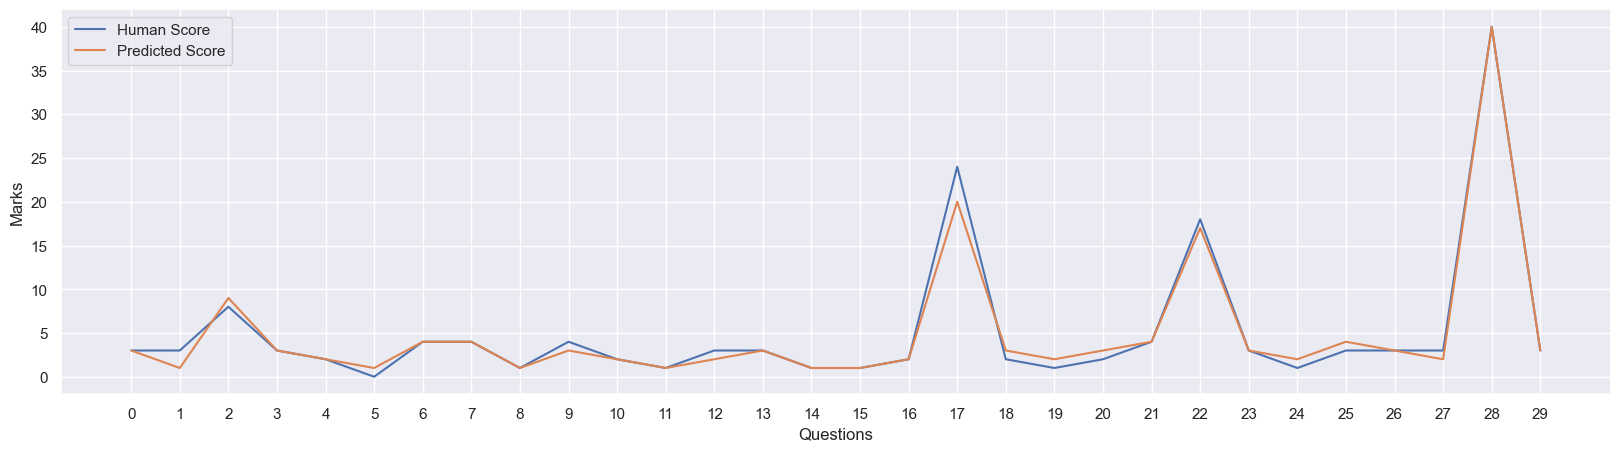

In [81]:
plot()